In [1]:
pip install --upgrade xgboost

In [57]:
import xgboost
print(xgboost.__version__)

2.1.1


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from scipy import stats  # Import scipy.stats for statistical analysis

In [59]:
from google.colab import files
uploaded = files.upload()

Saving ts_imputed_xgboost.csv to ts_imputed_xgboost (1).csv


In [60]:
df = pd.read_csv('ts_imputed_xgboost.csv')

In [61]:
df.sample(10)

,Country,year,HIV_seropositivity_genpop,Linkage_to_ART,HIV_seropositivity_PMTCT,percent_VLC,percent_VLS,percent_Not_on_ART,new_on_PrEP,GINI_index,MMR,percent_pop_0.14yrs,percent_pop_15.64yrs
164,Zimbabwe,2021,5.75,94.59,10.87,54.67,93.90,1.92,37916,54.5,218,40.89,55.74
43,Democratic Republic of the Congo,2020,5.91,96.89,1.41,71.46,90.32,0.88,1383,44.7,547,46.49,50.51
116,Rwanda,2021,2.20,64.72,2.48,93.87,95.70,1.66,8999,36.2,238,38.89,57.97
152,Zambia,2017,5.59,67.31,12.44,25.01,79.47,0.00,332,40.5,156,44.86,53.46
106,Nigeria,2019,3.50,97.25,2.54,70.11,85.99,4.22,379,50.5,1122,43.71,53.28
151,Uganda,2024,1.61,95.54,4.32,90.33,96.11,3.05,203046,53.3,108,39.33,57.71
83,Malawi,2020,3.24,88.53,6.61,59.53,92.84,5.76,189,46.6,381,43.73,53.48
89,Mozambique,2018,4.96,82.66,7.77,32.63,72.40,0.00,1630,46.6,160,44.26,53.16
118,Rwanda,2023,1.47,68.44,1.99,93.86,98.33,1.31,11722,38.6,238,38.07,58.66
165,Zimbabwe,2022,5.64,95.68,10.14,71.04,96.39,1.80,75371,51.3,135,40.63,56.04


In [62]:
# Data Preparation
df['year'] = pd.to_datetime(df['year'], format='%Y')  # Convert 'year' column to datetime format
df.set_index('year', inplace=True)  # Set 'year' column as index

In [8]:
df.shape

(168, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2017-01-01 to 2024-01-01
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    168 non-null    object 
 1   HIV_seropositivity_genpop  168 non-null    float64
 2   Linkage_to_ART             168 non-null    float64
 3   HIV_seropositivity_PMTCT   168 non-null    float64
 4   percent_VLC                168 non-null    float64
 5   percent_VLS                168 non-null    float64
 6   percent_Not_on_ART         168 non-null    float64
 7   new_on_PrEP                168 non-null    int64  
 8   GINI_index                 168 non-null    float64
 9   MMR                        168 non-null    int64  
 10  percent_pop_0.14yrs        168 non-null    float64
 11  percent_pop_15.64yrs       168 non-null    float64
dtypes: float64(9), int64(2), object(1)
memory usage: 17.1+ KB


In [63]:
df.head()

,Country,HIV_seropositivity_genpop,Linkage_to_ART,HIV_seropositivity_PMTCT,percent_VLC,percent_VLS,percent_Not_on_ART,new_on_PrEP,GINI_index,MMR,percent_pop_0.14yrs,percent_pop_15.64yrs
year,,,,,,,,,,,,
2017-01-01,Angola,8.89,56.95,4.92,34.23,68.38,0.00,578,51.3,253,45.64,51.81
2018-01-01,Angola,8.18,57.21,2.48,52.32,70.44,0.00,14,51.3,233,45.55,51.89
2019-01-01,Angola,6.31,65.79,0.75,53.68,72.47,9.80,441,51.3,228,45.43,52.00
2020-01-01,Angola,5.43,75.55,4.87,8.01,72.33,29.47,204,51.3,222,45.31,52.10
2021-01-01,Angola,5.45,77.61,4.96,26.33,70.08,6.47,578,51.3,125,45.18,52.23


In [64]:
# Define the selected time-based features for analysis
features = ['HIV_seropositivity_genpop', 'Linkage_to_ART', 'HIV_seropositivity_PMTCT', 'percent_VLC',
            'percent_VLS', 'percent_Not_on_ART', 'new_on_PrEP','GINI_index','MMR','percent_pop_0.14yrs','percent_pop_15.64yrs']

In [65]:
# Compute Average VLS Rate at Baseline (2017) and at 2024
vls_rate_2017 = df.loc['2017', 'percent_VLS'].mean()  # Average VLS Rate for 2017
vls_rate_2024 = df.loc['2024', 'percent_VLS'].mean()  # Average VLS Rate for 2024

In [66]:
print(f'Average VLS Rate in 2017: {vls_rate_2017:.2f}%')
print(f'Average VLS Rate in 2024: {vls_rate_2024:.2f}%')

Average VLS Rate in 2017: 82.93%
Average VLS Rate in 2024: 95.59%


In [67]:
# Difference-in-Difference Analysis
# Create a binary indicator for baseline (2017) and endline (2024)
df['year'] = 0  # Default to 0
df.loc['2024', 'year'] = 1  # Set 1 for 2024

In [68]:
# Perform DiD Analysis
# Calculate the average VLS rate by period and treatment
baseline_avg = df[df['year'] == 0]['percent_VLS'].mean()
endline_avg = df[df['year'] == 1]['percent_VLS'].mean()

In [69]:
# Create a treatment indicator for whether it is the intervention group
df['treatment'] = np.where(df.index.year == 2024, 1, 0)  # Assuming 2024 as post-intervention

In [70]:
# Perform DiD Analysis
# Calculate the average VLS rate by period and treatment
baseline_avg = df[df['year'] == 0]['percent_VLS'].mean()
endline_avg = df[df['year'] == 1]['percent_VLS'].mean()

In [71]:
# Calculate the difference-in-difference
diff_in_diff = (endline_avg - baseline_avg)

In [72]:
print(f'Difference in VLS Rate between 2024 and 2017: {diff_in_diff:.2f}%')

Difference in VLS Rate between 2024 and 2017: 5.23%


In [73]:
# Conduct t-test to check for significance
t_stat, p_val = stats.ttest_ind(df[df['year'] == 0]['percent_VLS'], df[df['year'] == 1]['percent_VLS'])
print(f"T-test Statistic: {t_stat:.4f}, P-value: {p_val:.4f}")

if p_val < 0.05:
    print("The difference in VLS Rate between 2017 and 2024 is statistically significant.")
else:
    print("The difference in VLS Rate between 2017 and 2024 is not statistically significant.")

T-test Statistic: -3.2167, P-value: 0.0016
The difference in VLS Rate between 2017 and 2024 is statistically significant.


# Machine Leaning Model

In [74]:
# Step 1: Filter the DataFrame to include only the relevant features
df = df[features]

In [75]:
# Assuming your DataFrame is named 'df' and 'percent_VLS' is the target variable

# Step 1: Apply log transformation to the target variable
df['log_percent_VLS'] = np.log(df['percent_VLS'] + 1)  # Adding 1 to avoid log(0)

In [76]:
# Prepare the features (X) and the target variable (y)
X = df.drop(['percent_VLS', 'log_percent_VLS'], axis=1)
y = df['log_percent_VLS']

In [77]:
# Prepare the features (X) and the target variable (y)
X = df.drop(['percent_VLS', 'log_percent_VLS'], axis=1)
y = df['log_percent_VLS']

In [78]:
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [79]:
# Step 4: Train the XGBoost model
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [80]:
# Step 5: Predict using the model
y_pred_train = xgbr.predict(X_train)
y_pred_test = xgbr.predict(X_test)

In [81]:
# Step 6: Revert log transformation using exponential function
y_pred_train_exp = np.exp(y_pred_train) - 1
y_pred_test_exp = np.exp(y_pred_test) - 1
y_train_exp = np.exp(y_train) - 1
y_test_exp = np.exp(y_test) - 1

In [82]:
# Step 7: Calculate RMSE on the original scale
rmse_train = np.sqrt(mean_squared_error(y_train_exp, y_pred_train_exp))
rmse_test = np.sqrt(mean_squared_error(y_test_exp, y_pred_test_exp))

In [83]:
print(f'RMSE on Training set: {rmse_train:.4f}')
print(f'RMSE on Testing set: {rmse_test:.4f}')

RMSE on Training set: 0.0744
RMSE on Testing set: 2.7082


In [84]:
# Step 8: Plot feature importance with Viridis colormap
# Get feature importance scores
feature_importance = xgbr.feature_importances_
feature_names = X_train.columns

In [85]:
# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


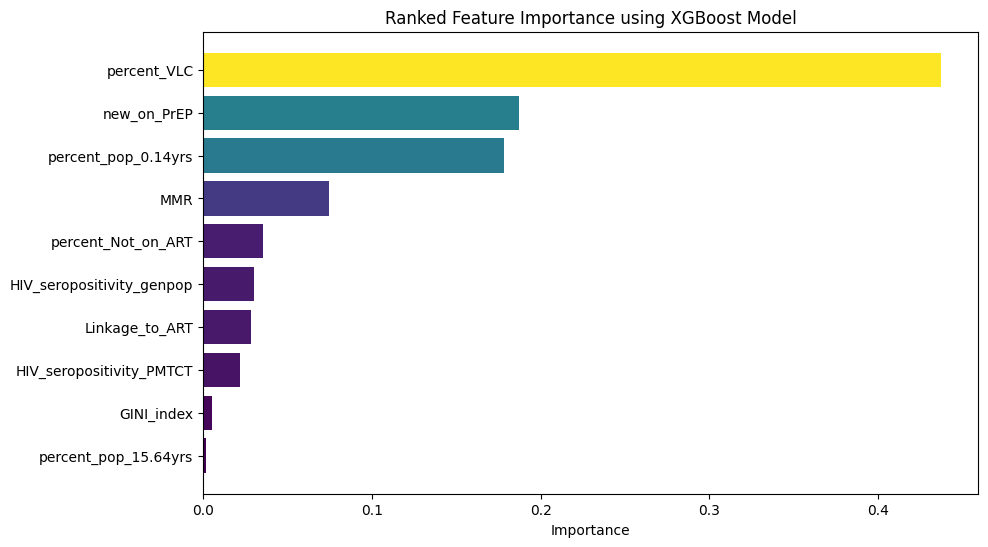

In [87]:
# Plotting feature importance using Viridis colormap
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=plt.cm.viridis(importance_df['Importance'] / max(importance_df['Importance'])))
plt.xlabel('Importance')
plt.title('Ranked Feature Importance using XGBoost Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

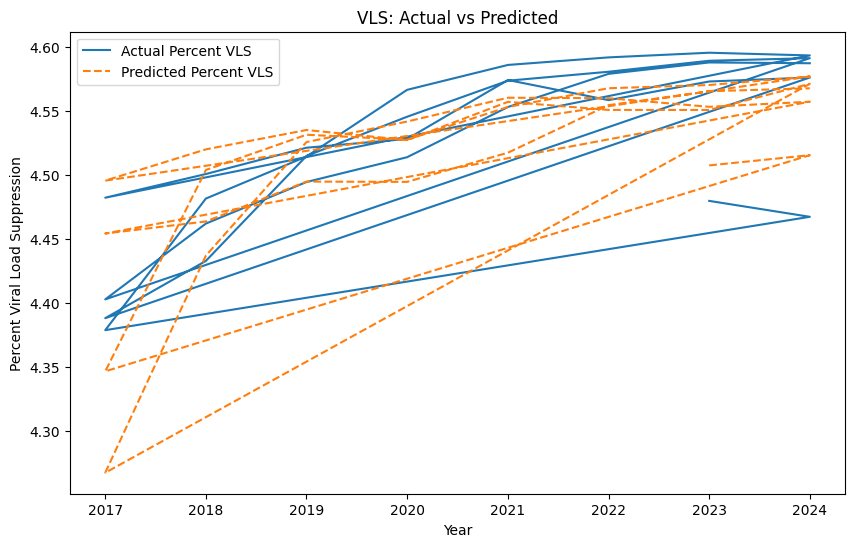

In [31]:
# Results and Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Percent VLS')
plt.plot(y_test.index, y_pred_test, label='Predicted Percent VLS', linestyle='--')
plt.title('VLS: Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Percent Viral Load Suppression')
plt.legend()
plt.show()

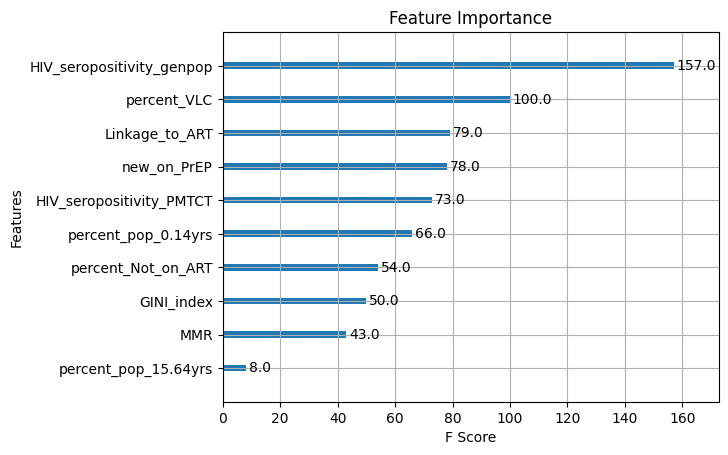

In [32]:
# Feature Importance
xgb.plot_importance(xgbr, max_num_features=10, importance_type='weight', title='Feature Importance', xlabel='F Score', ylabel='Features')
plt.show()

In [33]:
# Forecasting for the next 6 years (2025-2030)
future_years = pd.date_range(start='2025-01-01', periods=6, freq='Y')
future_features = X.tail(6).values  # Using last 6 years data as example, replace with appropriate future data
future_pred = xgbr.predict(future_features)

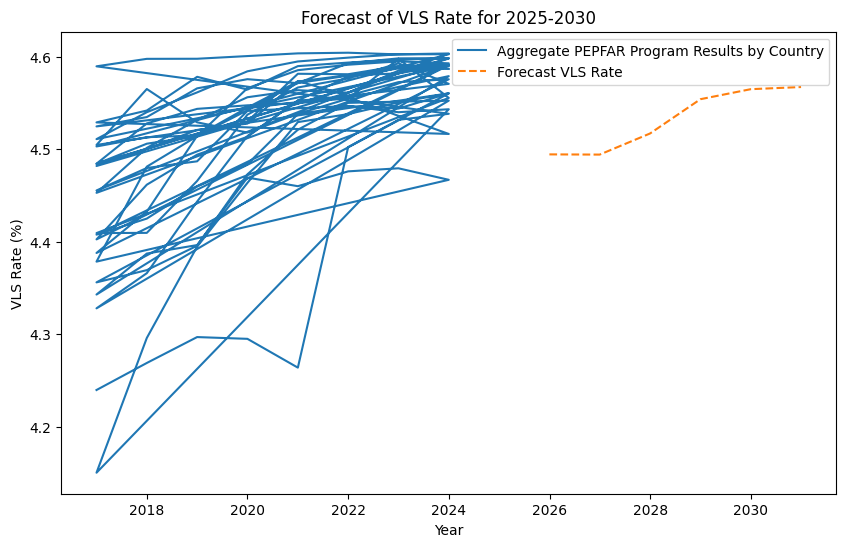

In [34]:
# Visualization of Forecast
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Aggregate PEPFAR Program Results by Country')
plt.plot(future_years, future_pred, label='Forecast VLS Rate', linestyle='--')
plt.title('Forecast of VLS Rate for 2025-2030')
plt.xlabel('Year')
plt.ylabel('VLS Rate (%)')
plt.legend()
plt.show()

In [35]:
# Error Analysis
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
error_df['Absolute Error'] = np.abs(error_df['Actual'] - error_df['Predicted'])
best_year = error_df['Absolute Error'].idxmin()
worst_year = error_df['Absolute Error'].idxmax()

In [36]:
print(f'Best Predicted Year: {best_year}')
print(f'Worst Predicted Year: {worst_year}')

Best Predicted Year: 2019-01-01 00:00:00
Worst Predicted Year: 2017-01-01 00:00:00


# Hyperparameter tuning

In [44]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer  # Ensure make_scorer is imported
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt

In [ ]:
# Assuming your DataFrame is named 'df'
# Define the selected time-based features for analysis
features = ['HIV_seropositivity_genpop', 'Linkage_to_ART', 'HIV_seropositivity_PMTCT', 'percent_VLC',
            'percent_VLS', 'percent_Not_on_ART', 'new_on_PrEP', 'GINI_index', 'MMR', 'percent_pop_0.14yrs', 'percent_pop_15.64yrs']


In [38]:
# Step 1: Filter the DataFrame to include only the relevant features
df = df[features]

In [39]:
# Step 2: Apply log transformation to the target variable
df['log_percent_VLS'] = np.log(df['percent_VLS'] + 1)  # Adding 1 to avoid log(0)


In [40]:
# Prepare the features (X) and the target variable (y)
X = df.drop(['percent_VLS', 'log_percent_VLS'], axis=1)
y = df['log_percent_VLS']

In [41]:
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [42]:
# Step 4: Define the hyperparameter distribution for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5]
}


In [45]:
# Define a custom scorer using RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


In [46]:
# Step 5: Set up the RandomizedSearchCV with the XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror')

random_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=param_dist,
    scoring=rmse_scorer,
    cv=5,
    n_iter=50,  # Number of parameter settings that are sampled
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [47]:
# Step 6: Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=2)

In [48]:
# Step 7: Retrieve the best model from RandomizedSearchCV
best_xgbr = random_search.best_estimator_

In [49]:
# Step 8: Predict using the best model
y_pred_train = best_xgbr.predict(X_train)
y_pred_test = best_xgbr.predict(X_test)

In [50]:
# Step 9: Revert log transformation using the exponential function
y_pred_train_exp = np.exp(y_pred_train) - 1
y_pred_test_exp = np.exp(y_pred_test) - 1
y_train_exp = np.exp(y_train) - 1
y_test_exp = np.exp(y_test) - 1

In [51]:
# Step 10: Calculate RMSE on the original scale
rmse_train = np.sqrt(mean_squared_error(y_train_exp, y_pred_train_exp))
rmse_test = np.sqrt(mean_squared_error(y_test_exp, y_pred_test_exp))

In [52]:
print(f'Best Parameters from RandomizedSearchCV: {random_search.best_params_}')
print(f'RMSE on Training set: {rmse_train:.4f}')
print(f'RMSE on Testing set: {rmse_test:.4f}')

Best Parameters from RandomizedSearchCV: {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
RMSE on Training set: 0.3188
RMSE on Testing set: 3.4500


In [53]:
# Step 11: Plot feature importance
# Get feature importance scores
feature_importance = best_xgbr.feature_importances_
feature_names = X_train.columns

In [54]:
# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

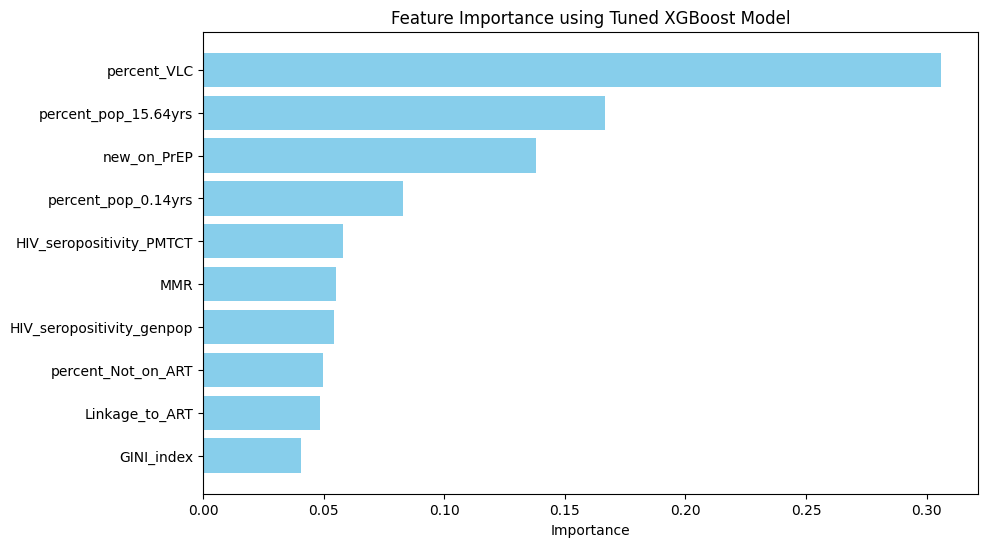

In [55]:
# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance using Tuned XGBoost Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()